<a href="https://colab.research.google.com/github/KoreTane/MKTBank/blob/main/MKTBank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install pyspark


# Exploratory Analysis

## Customer Profile
###The profile of our customer is as follows:
* Age Range: Adults in their 40s.
* Marital Status: Predominantly married, with children (which aligns with the average number of children per couple in Europe).
* Profession: Most customers work in administrative, operational, and technical fields.
* Social Class: Customers belong to classes B and C.
* Financial Behavior: They are considered good payers.
Half have a home loan. A small portion has personal credit.

## Technical Profile of Contacts
###The characteristics of the contacts are as follows:
* Contact Method: The majority of interactions are conducted via mobile phone.
* Contact Frequency: Contacts occur more frequently at the end of the year and during the last days of the month, especially starting from the 20th.
* Call Duration: The average duration of calls is between 6 to 7 minutes.
More than half of the calls do not reach this duration, suggesting that many contacts are made with uninterested individuals or those already predisposed to adopting the product.
* Sales Effectiveness: Typically, sales are finalized within three contacts, and half of the customers end up purchasing the product.



In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import col, count, when
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

spark = SparkSession.builder.appName("BankMarketing").getOrCreate()
df = spark.read.csv("bank.csv", header=True, inferSchema=True)
# Create ID Client
df = df.withColumn("client_id", monotonically_increasing_id())

colunas = ['client_id'] + [col for col in df.columns if col != 'client_id']
df = df.select(colunas)

df.show(10)

df.printSchema()

df.summary().show()

+---------+---+----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|client_id|age|       job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---------+---+----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|        0| 59|    admin.| married|secondary|     no|   2343|    yes|  no|unknown|  5|  may|    1042|       1|   -1|       0| unknown|    yes|
|        1| 56|    admin.| married|secondary|     no|     45|     no|  no|unknown|  5|  may|    1467|       1|   -1|       0| unknown|    yes|
|        2| 41|technician| married|secondary|     no|   1270|    yes|  no|unknown|  5|  may|    1389|       1|   -1|       0| unknown|    yes|
|        3| 55|  services| married|secondary|     no|   2476|    yes|  no|unknown|  5|  may|     579|       1|   -1|       0| unknown|    yes|

In [3]:
total_count = df.count()

distinct_count = df.distinct().count()

if total_count > distinct_count:
    print("Diplicates: Yes.")
else:
    print("Duplicates: No.")

Duplicates: No.


In [4]:
# Simple Analyses
# 1. age: Count how many IDs are over 80 years old
age_above_80 = df.filter(df.age > 80).count()

# 2. Count IDs grouped by job and calculate the average balance
job_count = df.groupBy("job") \
               .agg(
                   F.count("*").alias("count"),  # Count of IDs
                   F.format_number(F.avg("balance"), 2).alias("average_balance")  # Average balance formatted
               ) \
               .sort(F.col("count").desc())

# 3. marital: Count IDs grouped by marital status
marital_count = df.groupBy("marital").count().sort(col("count").desc())

# 4. Count IDs grouped by education level and calculate the average balance
education_count = df.groupBy("education") \
                     .agg(
                         F.count("*").alias("count"),  # Count of IDs
                         F.format_number(F.avg("balance"), 2).alias("average_balance")  # Average balance formatted
                     ) \
                     .sort(F.col("count").desc())

# 5. default: Count IDs with and without credit in arrears
default_count = df.groupBy("default").count().sort(col("count").desc())

# 6. balance: Count how many IDs have negative and positive balances
balance_count = df.groupBy(F.when(df.balance < 0, "Negative").otherwise("Positive").alias("Balance")).count()

# 7. housing: Count how many IDs have housing loans and how many do not
housing_count = df.groupBy("housing").count().sort(col("count").desc())

# 8. loan: Count how many IDs have loans and how many do not
loan_count = df.groupBy("loan").count().sort(col("count").desc())

# 9. contact: Count the number of IDs grouped by contact method
contact_count = df.groupBy("contact").count().sort(col("count").desc())

# 10. day: Count the distribution of contacts by day of the month
day_count = df.groupBy("day").count().sort(col("count").desc())

# 11. month: Count the distribution of contacts by month
month_count = df.groupBy("month").count().sort(col("count").desc())

# 12. duration: Count how many IDs have contact duration above and below the average
average_duration = df.select(F.avg("duration")).first()[0]
duration_count = df.groupBy(F.when(df.duration < average_duration, "Below Average").otherwise("Above Average").alias("Duration")).count().sort(col("count").desc())

# 13. campaign: Distribution of contacts made during the campaign
campaign_count = df.groupBy("campaign").count().sort(col("count").desc())

# 14. pdays: Distribution of the number of days since the last contact (999 means never contacted)
pdays_count = df.groupBy(F.when(df.pdays == 999, "Never contacted").otherwise(df.pdays)).count().sort(col("count").desc())

# 15. previous: Distribution of the number of previous contacts
previous_count = df.groupBy("previous").count().sort(col("count").desc())

# 16. poutcome: Count results from the previous campaign
poutcome_count = df.groupBy("poutcome").count().sort(col("count").desc())

# 17. deposit: Count acceptance of the offer (yes/no)
deposit_count = df.groupBy("deposit").count()

# Displaying results in a matrix

print("Complete Customer Analysis:")

print(f"\n1. IDs over 80 years old: {age_above_80}")

print("\n2. Count of IDs grouped by Job:")
job_count.show()

print("\n3. Count of IDs grouped by Marital Status:")
marital_count.show()

print("\n4. Count of IDs grouped by Education Level:")
education_count.show()

print("\n5. Count of IDs with and without Credit in Arrears:")
default_count.show()

print("\n6. Count of IDs with Negative and Positive Balance:")
balance_count.show()

print("\n7. Count of IDs with Housing:")
housing_count.show()

print("\n8. Count of IDs with Loan:")
loan_count.show()

print("\n9. Count of IDs grouped by Contact:")
contact_count.show()

print("\n10. Distribution of contacts by Day of the Month:")
day_count.show()

print("\n11. Distribution of contacts by Month:")
month_count.show()

print("\n12. The average is: 371 seconds. Duration of contact (Below/Above Average):")
duration_count.show()

print("\n13. Distribution of contacts made during the Campaign:")
campaign_count.show()

print("\n14. Distribution of Number of Days since Last Contact:")
pdays_count.show()

print("\n15. Distribution of Number of Previous Contacts:")
previous_count.show()

print("\n16. Results from Previous Campaign:")
poutcome_count.show()

print("\n17. Acceptance of Offer (Yes/No):")
deposit_count.show()

Complete Customer Analysis:

1. IDs over 80 years old: 55

2. Count of IDs grouped by Job:
+-------------+-----+---------------+
|          job|count|average_balance|
+-------------+-----+---------------+
|   management| 2566|       1,793.66|
|  blue-collar| 1944|       1,203.93|
|   technician| 1823|       1,556.29|
|       admin.| 1334|       1,195.87|
|     services|  923|       1,081.17|
|      retired|  778|       2,417.25|
|self-employed|  405|       1,865.37|
|      student|  360|       1,500.78|
|   unemployed|  357|       1,314.72|
| entrepreneur|  328|       1,621.94|
|    housemaid|  274|       1,366.16|
|      unknown|   70|       1,945.46|
+-------------+-----+---------------+


3. Count of IDs grouped by Marital Status:
+--------+-----+
| marital|count|
+--------+-----+
| married| 6351|
|  single| 3518|
|divorced| 1293|
+--------+-----+


4. Count of IDs grouped by Education Level:
+---------+-----+---------------+
|education|count|average_balance|
+---------+-----+------

In [5]:
# del lines where age > 80 or balance > 10000
df = df.filter(
    (df.age <= 80) &
    (df.balance <= 10000) &
    (df.balance >= -2000) &
    (df.job != "unknown") &
    (df.education != "unknown")
)

# Substitute "unknown" for "não informado" in colunms contact and poutcome
df = df.withColumn("contact", F.when(df.contact == "unknown", "não informado").otherwise(df.contact)) \
       .withColumn("poutcome", F.when(df.poutcome == "unknown", "não informado").otherwise(df.poutcome))

df.show()


+---------+---+-----------+--------+---------+-------+-------+-------+----+-------------+---+-----+--------+--------+-----+--------+-------------+-------+
|client_id|age|        job| marital|education|default|balance|housing|loan|      contact|day|month|duration|campaign|pdays|previous|     poutcome|deposit|
+---------+---+-----------+--------+---------+-------+-------+-------+----+-------------+---+-----+--------+--------+-----+--------+-------------+-------+
|        0| 59|     admin.| married|secondary|     no|   2343|    yes|  no|não informado|  5|  may|    1042|       1|   -1|       0|não informado|    yes|
|        1| 56|     admin.| married|secondary|     no|     45|     no|  no|não informado|  5|  may|    1467|       1|   -1|       0|não informado|    yes|
|        2| 41| technician| married|secondary|     no|   1270|    yes|  no|não informado|  5|  may|    1389|       1|   -1|       0|não informado|    yes|
|        3| 55|   services| married|secondary|     no|   2476|    yes|

In [6]:
# Creating the Spark session
#spark = SparkSession.builder.appName("CorrelationMatrix").getOrCreate()

#categorical_cols = ['job', 'marital', 'education', 'month','deposit']
#numerical_cols = ['age', 'balance', 'duration']

# Transform categorical variables into numeric ones
#indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index") for col in categorical_cols]
#for indexer in indexers:
#    df = indexer.fit(df).transform(df)

# Select the necessary columns
#df_indexed = df.select([F.col(f"{col}_index") for col in categorical_cols] + [F.col(col) for col in numerical_cols])

# Convert to Pandas DataFrame for plotting the correlation matrix
#df_pandas = df_indexed.toPandas()

# Calcu the correlation matrix
#correlation_matrix = df_pandas.corr()

# Plot the correlation matrix
#plt.figure(figsize=(12, 10))
#sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
#plt.title('Correlation Matrix')
#plt.show()

In [7]:
# Assuming df is the existing DataFrame
# Creating AgeRange column
df = df.withColumn("AgeRange",
                   when((col("age") >= 18) & (col("age") <= 25), "Jovem")
                   .when((col("age") > 25) & (col("age") <= 35), "Jovem Adulto")
                   .when((col("age") > 35) & (col("age") <= 55), "Adulto")
                   .otherwise("Idoso"))

# Creating PorN column
df = df.withColumn("PorN",
                   when(col("balance") > 0, "Positive")
                   .otherwise("Negative"))

# Creating DaysM column
df = df.withColumn("DaysM",
                   when((col("day") >= 1) & (col("day") <= 8), "Beginning")
                   .when((col("day") > 8) & (col("day") <= 23), "Middle")
                   .otherwise("End"))

# Creating Trimestry column
df = df.withColumn("Trimestry",
                   when(col("month").isin(["jan", "feb", "mar"]), "Q1")
                   .when(col("month").isin(["apr", "may", "jun"]), "Q2")
                   .when(col("month").isin(["jul", "aug", "sep"]), "Q3")
                   .otherwise("Q4"))

# Creating DurationRecurse column
df = df.withColumn("DurationRecurse",
                   when((col("duration") >= 0) & (col("duration") <= 120), "Short")
                   .when((col("duration") > 120) & (col("duration") <= 240), "Medium")
                   .otherwise("Long"))

# Creating ProfessionGroup column
df = df.withColumn("ProfessionGroup",
                   when(col("job").isin(["management", "entrepreneur", "self-employed"]), "Executives and High Earners")
                   .when(col("job").isin(["technician", "admin.", "blue-collar"]), "Skilled Workers")
                   .when(col("job").isin(["services", "housemaid", "unemployed", "student"]), "Services and Support")
                   .otherwise("Others"))

# Displaying the modified DataFrame
df.show(10)


+---------+---+----------+--------+---------+-------+-------+-------+----+-------------+---+-----+--------+--------+-----+--------+-------------+-------+------------+--------+---------+---------+---------------+--------------------+
|client_id|age|       job| marital|education|default|balance|housing|loan|      contact|day|month|duration|campaign|pdays|previous|     poutcome|deposit|    AgeRange|    PorN|    DaysM|Trimestry|DurationRecurse|     ProfessionGroup|
+---------+---+----------+--------+---------+-------+-------+-------+----+-------------+---+-----+--------+--------+-----+--------+-------------+-------+------------+--------+---------+---------+---------------+--------------------+
|        0| 59|    admin.| married|secondary|     no|   2343|    yes|  no|não informado|  5|  may|    1042|       1|   -1|       0|não informado|    yes|       Idoso|Positive|Beginning|       Q2|           Long|     Skilled Workers|
|        1| 56|    admin.| married|secondary|     no|     45|     no

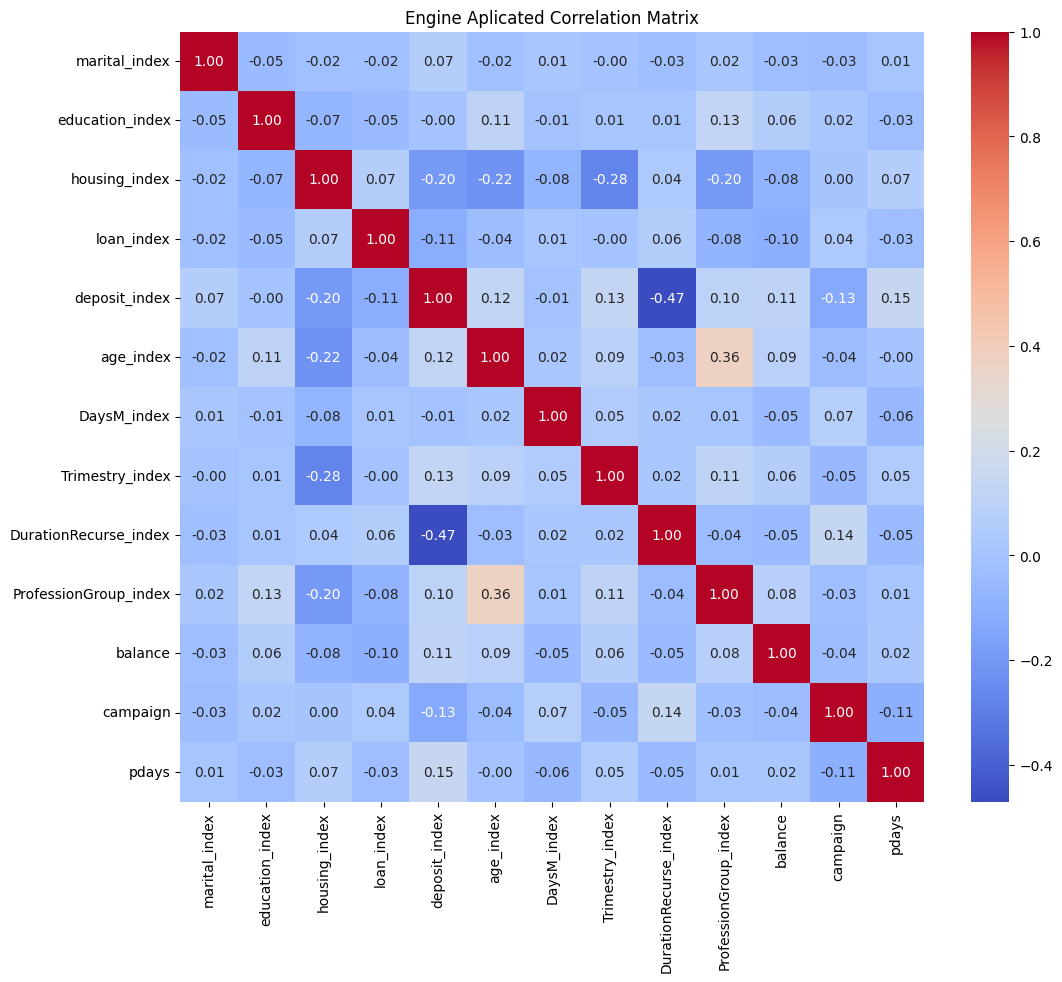

In [8]:
# Creating the Spark session
#spark = SparkSession.builder.appName("CorrelationMatrix").getOrCreate()

categorical_cols2 = ['marital', 'education', 'housing', 'loan', 'deposit', 'age',
                    'DaysM', 'Trimestry', 'DurationRecurse', 'ProfessionGroup']

numerical_cols2 = ['balance', 'campaign', 'pdays']

# Transform categorical variables into numeric ones
indexers2 = [StringIndexer(inputCol=col, outputCol=f"{col}_index") for col in categorical_cols2]
for indexer in indexers2:
    df = indexer.fit(df).transform(df)

# Select the necessary columns
df_indexed2 = df.select([F.col(f"{col}_index") for col in categorical_cols2] + [F.col(col) for col in numerical_cols2])

# Convert to Pandas DataFrame for plotting the correlation matrix
df_pandas2 = df_indexed2.toPandas()

# Calcu the correlation matrix
correlation_matrix2 = df_pandas2.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix2, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Engine Aplicated Correlation Matrix')
plt.show()

In [9]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler

# Criando um vetor de características
assembler2 = VectorAssembler(inputCols=[f"{col}_index" for col in categorical_cols2] + numerical_cols2, outputCol="features")
df_features2 = assembler2.transform(df_indexed2) # Changed df_indexed to df_indexed2

# Treinando o modelo Random Forest
rf2 = RandomForestClassifier(labelCol="deposit_index", featuresCol="features", maxBins=64) # Increased maxBins to 64
model2 = rf2.fit(df_features2) # Changed df_features to df_features2

# Obtendo a importância das variáveis
importances2 = model2.featureImportances
# Converting SparseVector to dense vector (numpy array) for sorting
importances_dense2 = importances2.toArray()

importance_df2 = pd.DataFrame({
    'Feature': [f"{col}_index" for col in categorical_cols2] + numerical_cols2,
    'Importance': importances_dense2 # Using dense vector here
}).sort_values(by='Importance', ascending=False)

print(importance_df2)

                  Feature  Importance
4           deposit_index    0.858915
8   DurationRecurse_index    0.091175
12                  pdays    0.022542
2           housing_index    0.010967
10                balance    0.005628
5               age_index    0.004207
7         Trimestry_index    0.001975
11               campaign    0.001818
3              loan_index    0.001527
0           marital_index    0.000607
9   ProfessionGroup_index    0.000312
6             DaysM_index    0.000247
1         education_index    0.000079
